In [1]:
import numpy as np
for name in ["gridkit_europe","gridkit_north_america"]:
    a = np.loadtxt("./Dataset/GridNetwork/"+name+".csv",usecols=[1,2],skiprows=1, dtype=str,delimiter=",")
    np.savetxt("./Dataset/GridNetwork/"+name+".txt",a,fmt='%s')

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph
from sklearn.metrics import f1_score
import sys
sys.path.append("../")
from utils.reinforcement_learning.dqn_TS import DQN
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from utils.getClass import objective_function,get_class_from_file
        
def get_action(GRAPH,action,name):
    name = name.split("_")[0]
    geneName = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/"+name+"_Gene_List.txt",dtype=str)
    NCG_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/NCG_name.txt",dtype=str)
    CGC_Cancer = np.loadtxt("./Dataset/GeneNetwork/Gene_Feature/CGC_name.txt",dtype=str)
    count = 0 
    true_label = np.zeros(GRAPH.vcount())
    predicted_label = np.zeros(GRAPH.vcount())
    for i, personalizes_gene in enumerate(GRAPH.vs["name"]):
        gene = geneName[int(personalizes_gene)-1] 
        true_label[i] =  1 if (gene in NCG_Cancer) or (gene in CGC_Cancer) else 0
    for j, potential_gene in enumerate(action):
        cancer_index = GRAPH.vs[potential_gene]["name"]
        gene = geneName[int(cancer_index)-1] 
        predicted_label[j] =  1 if (gene in NCG_Cancer) or (gene in CGC_Cancer) else 0
    fscore = f1_score(true_label, predicted_label)
    return fscore, sum(predicted_label), sum(true_label)
    
def implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False):
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    action_list = np.loadtxt(fname, dtype=int)
    _, lcc, actions = EvaluateACTION(action_list,objectiveFunction,GRAPH,indexOn)
    if condMaxNum:
        l = np.array(lcc)
        lcc = (l[-1] - l + 1)/l[-1]
    else:
        lcc = np.array(lcc)/lcc[0]
    return lcc, actions
    #GRAPH.vertex["name"],

    
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model_iteration,parameter_path,GRAPH,useSingleStep= None):
    params = Params(parameter_path)
    objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    model = torch.load(params.checkpoint_dir+'_'+str(model_iteration))
    game = GraphGame
    env = Environment(game)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env,objectiveFunction,nodeCentrality,globalFeature, attacker,GRAPH,useSingleStep)
    return rewards, lcc, actions

def visual_evaluation(graph_path,file_list,list_parameter,best_model,action_list,save = False): 
    #figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(18, 6))
    for i, graph_name in enumerate(file_list):
        print(graph_name, end='=> ')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        print(N)
        action={}
        plt.figure(figsize=(18,6))
        for model, attacker in enumerate(list_parameter):
            print(name[model])
            rewards, result, actions = implement_GNN(best_model[model],attacker, GRAPH.copy(),useSingleStep=None)
            if name[model] == "MinMax":
                color_model = "#377eb8"
                condMaxNum = False
            elif name[model] == "CNP":
                color_model = "#4daf4a" 
                condMaxNum = False
            else:
                color_model = "#e41a1c"
                condMaxNum = True
                l = np.array(result)
                result = (l[-1] - l + 1)/l[-1]
            x =  np.flip(np.arange(N+1)[N:0:-1]/N)
            action[name[model]] = {"actions":actions}
            plt.plot(x[:len(result)],np.array(result)/result[0], color = color_model,label=name[model])
        plt.title(graph_name, fontdict={'fontsize': 18})
        plt.legend(loc="upper right") 
        plt.xlabel("Fraction of Nodes Removed", fontsize=18)
        plt.ylabel("ObjectiveFunction", fontsize=18)
        if save:
            plt.savefig("./Figure/Compiled/HDA/Powergrid/"+graph_name+".pdf")
        plt.show()
        action_list[graph_name] = action
    return action_list

In [2]:
import json
import sys
import json
from utils.evaluation.jsonEncoder import NpEncoder
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data


# Power Grid: EU Grid

gridkit_europe=> 13844
MinMax


/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


CNP
MaxNum


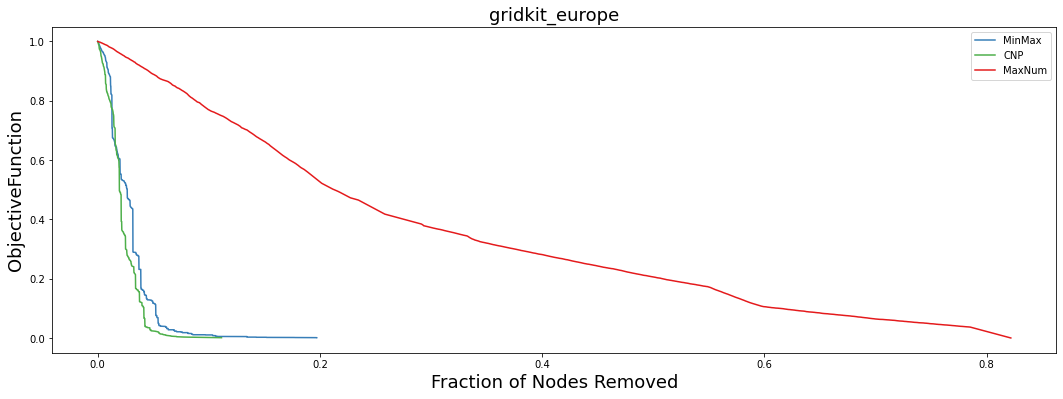

In [8]:
MIX_MinMax = 85000  
MIX_CNP = 98500
MIX_MaxNum = 284000 
parameter = ["./utils/hyperparameters/Mix/mixed_params_All.json",
             "./utils/hyperparameters/Mix/mixed_params_CN.json",
             "./utils/hyperparameters/Mix/mixed_params_MaxNum.json"
            ]
name = ["MinMax","CNP","MaxNum"]
best_model= [MIX_MinMax,MIX_CNP,MIX_MaxNum]
file_list = ["gridkit_europe"]
graph_path =  "./Dataset/GridNetwork/"
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Powergrid/powergrid.json")
JSON_FILE =visual_evaluation(graph_path,file_list,parameter,best_model,JSON_FILE,save=True)
with open("./Figure/Compiled/HDA/Powergrid/powergrid.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)

# Power Grid: North America Grid

gridkit_north_america=> 16167
MinMax


/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())
/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:36: RuntimeWarning: ARPACK solver failed to converge (3001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:821
  eigen_centrality = np.array(g.eigenvector_centrality())


CNP
MaxNum


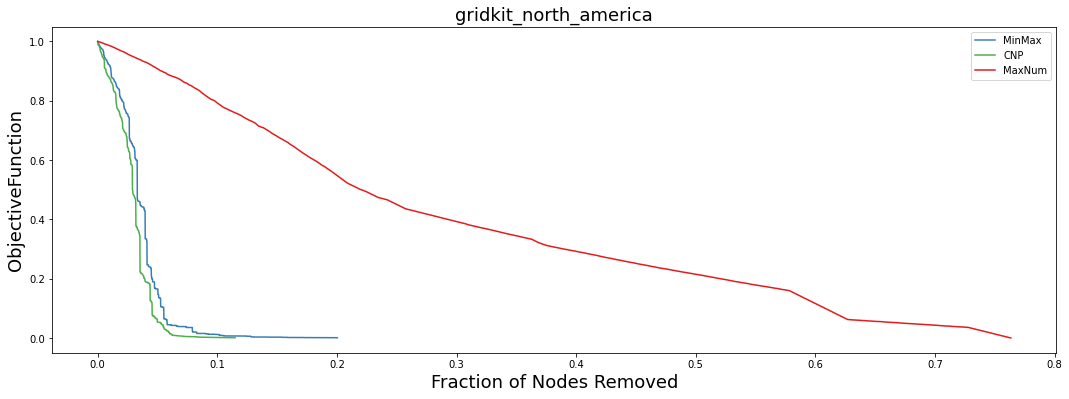

In [9]:
MIX_MinMax = 85000  
MIX_CNP = 98500
MIX_MaxNum = 284000 
parameter = ["./utils/hyperparameters/Mix/mixed_params_All.json",
             "./utils/hyperparameters/Mix/mixed_params_CN.json",
             "./utils/hyperparameters/Mix/mixed_params_MaxNum.json"
            ]
name = ["MinMax","CNP","MaxNum"]
best_model= [MIX_MinMax,MIX_CNP,MIX_MaxNum]
file_list = ["gridkit_north_america"]
graph_path =  "./Dataset/GridNetwork/"
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Powergrid/powergrid.json")
JSON_FILE =visual_evaluation(graph_path,file_list,parameter,best_model,JSON_FILE,save=True)
with open("./Figure/Compiled/HDA/Powergrid/powergrid.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)

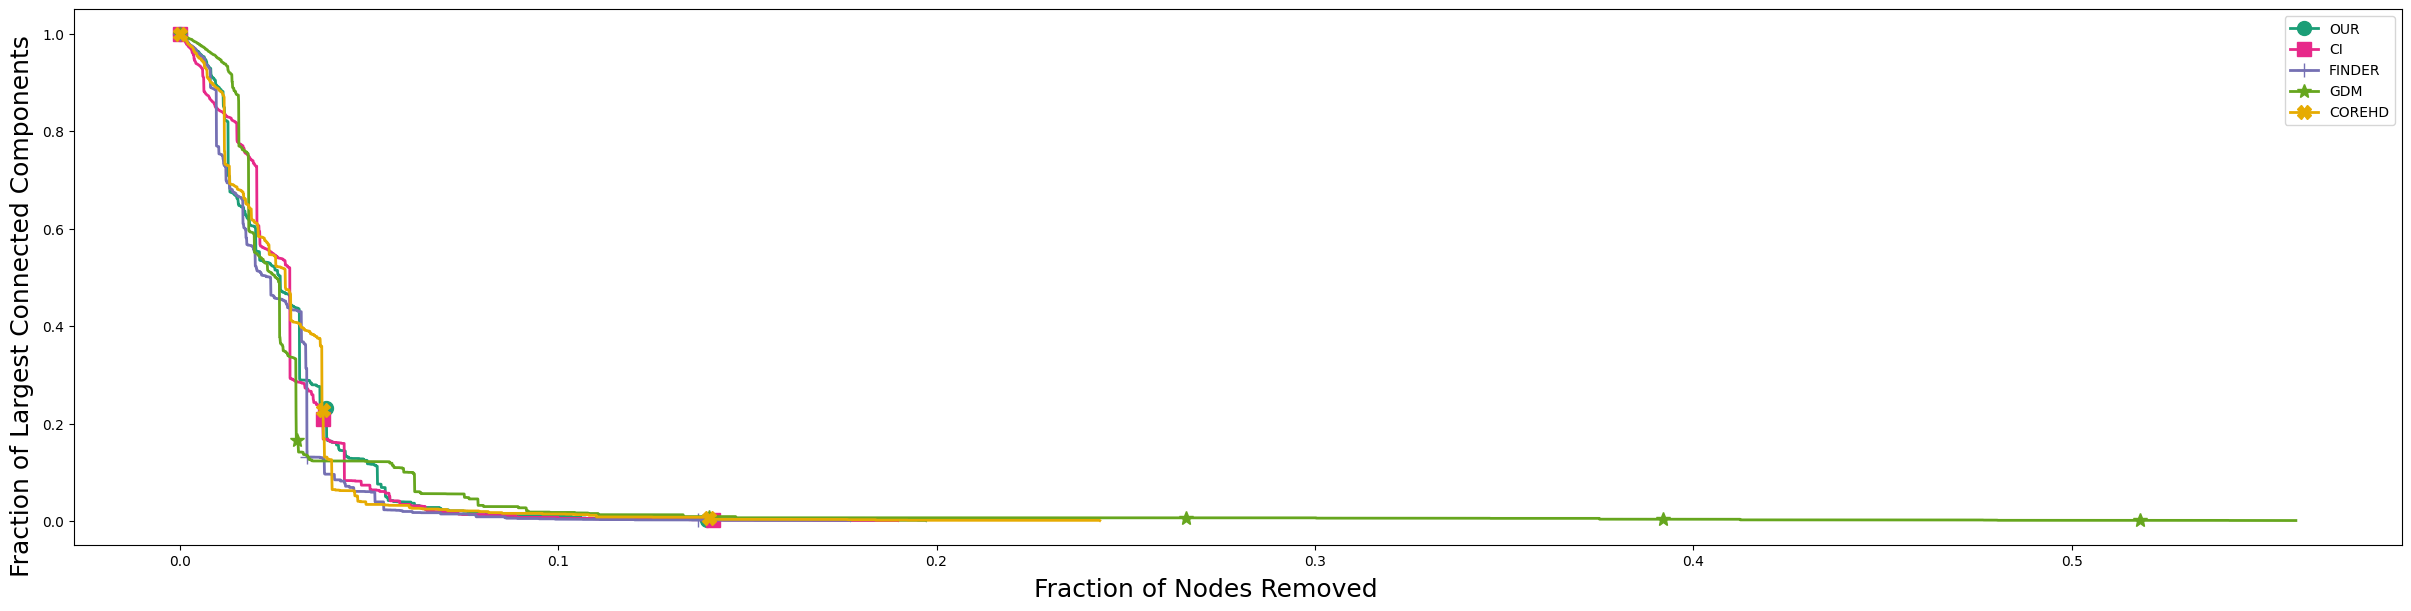

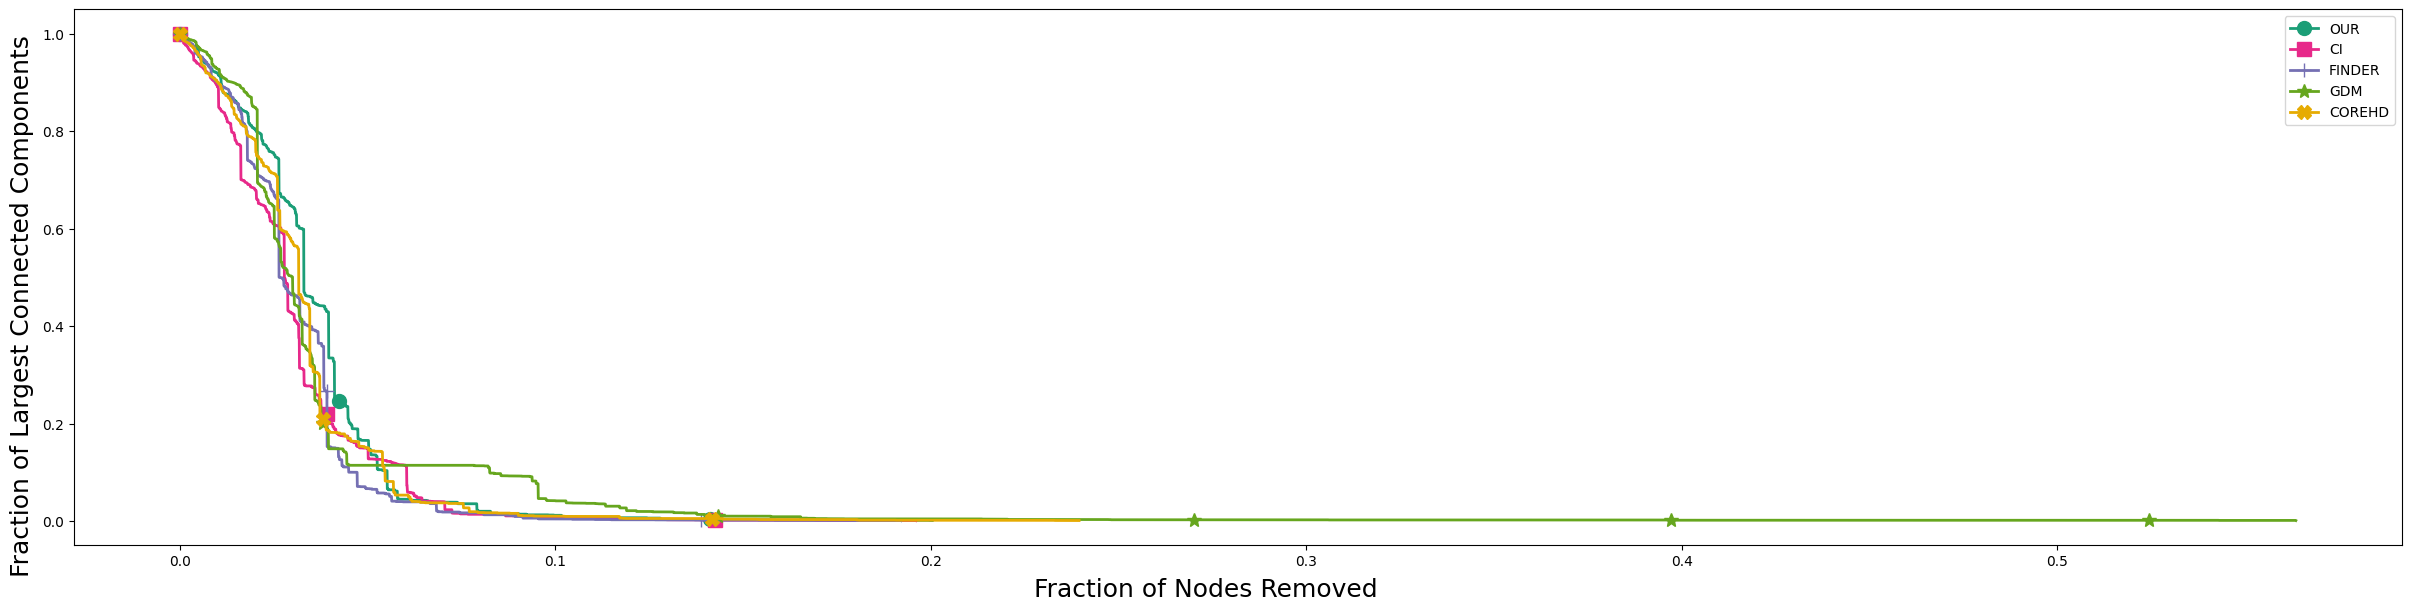

IndexError: list index out of range

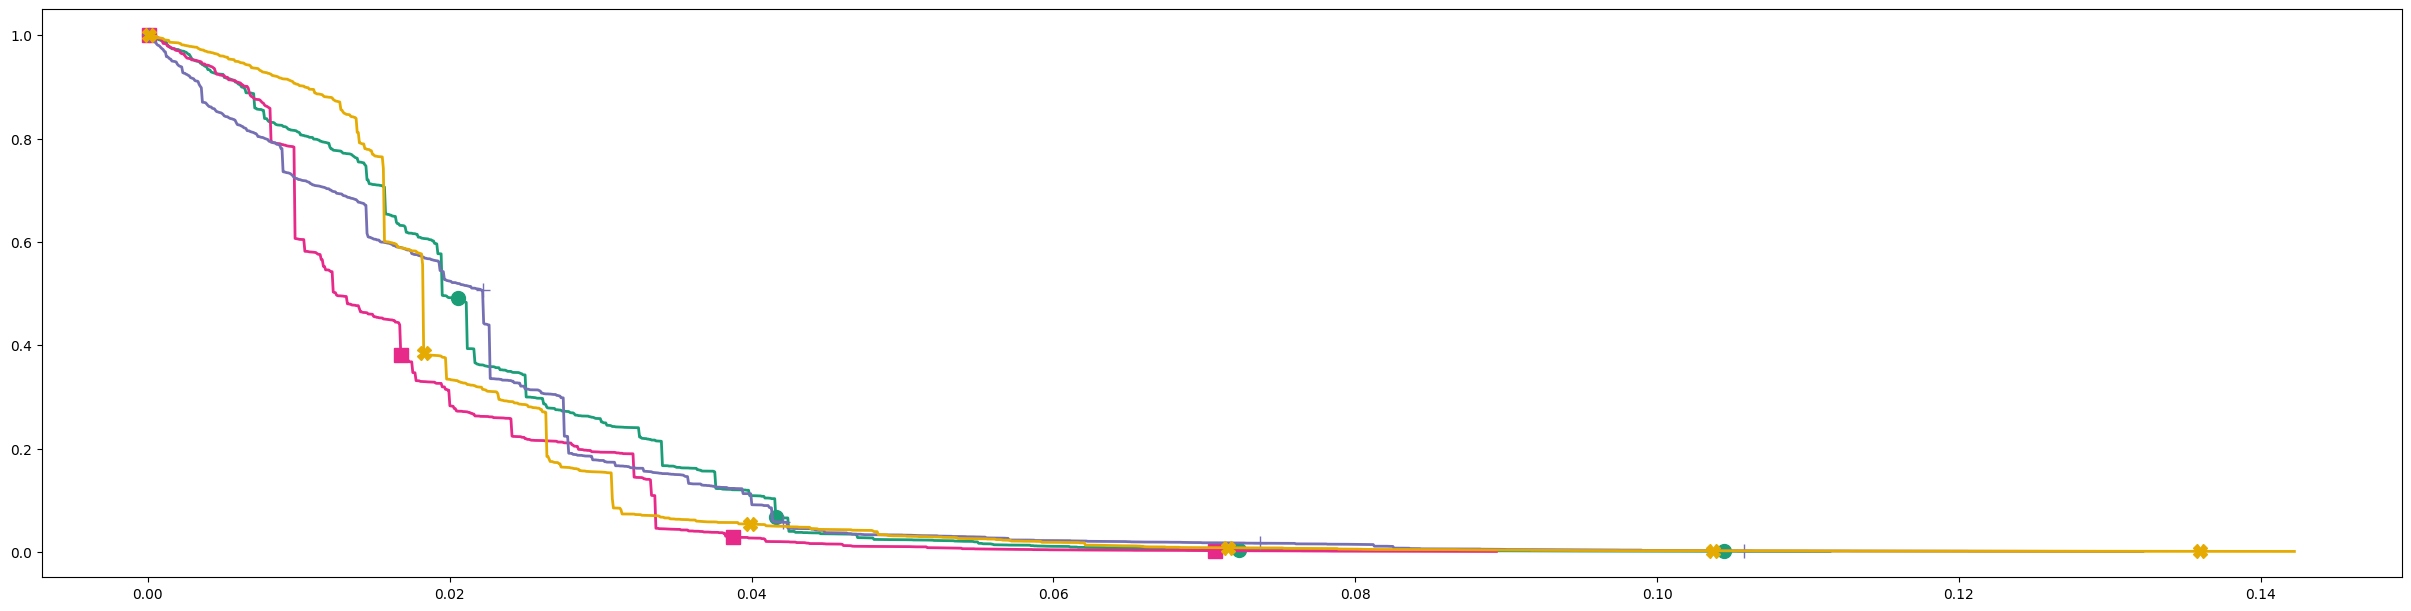

In [10]:
JSON_FILE = get_from_json("./Figure/Compiled/HDA/Powergrid/powergrid.json")
def get_SOAT(result,objFunc,graph_path,grid,plot_grid,file_list,title):
    figure, axis = plt.subplots(grid[0],grid[1],figsize=(24, 6), dpi=100, constrained_layout=True)
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        #result[res][objFunc]["model"]:
        x =  np.flip(np.arange(N+1)[N:0:-1]/N)
        if objFunc == "MinMax":
            model = {}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","largestConnectedComponent")
            GRAPH, map = input_graph(graph_path,graph_name)
            _, lcc_our, action_our = EvaluateACTION(result[graph_name][objFunc]["actions"],objectiveFunction,GRAPH,True)
            model["our"]=result[graph_name][objFunc]
            model["our"]["obj"]=np.array(lcc_our)/lcc_our[0]
            fname = "./FINDER/FINDER_ReTrained/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_finder, action_finder = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["finder"] = {
                    "actions":action_finder,
                    "obj":lcc_finder
            }            
            fname = "./CI/L_2/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_ci, action_ci = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False)
            model["ci"] = {
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./FINDER/FINDER_ReTrained/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_finder, action_finder = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["finder"] = {
                    "actions":action_finder,
                    "obj":lcc_finder
            }
            fname = "./GDM/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["gdm"] = {
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }
            fname = "./CoreHD/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_core, action_core = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False)
            model["core"] = {
                    "actions":action_core,
                    "obj":lcc_core
            }   
            color_model = ['#1b9e77','#e7298a','#7570b3','#66a61e','#e6ab02']
            labeling = ['our',  'ci','finder','gdm','corehd']
            marker = ['o',"s", "+",  "*","X"]
            condMaxNum = False
            ylabel = "Fraction of Largest Connected Components"

        elif objFunc == "CNP":
            model = {}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","pairwiseConnectivity")
            GRAPH, map = input_graph(graph_path,graph_name)
            _, lcc_our, action_our = EvaluateACTION(result[graph_name][objFunc]["actions"],objectiveFunction,GRAPH,True)
            model["our"]=result[graph_name][objFunc]
            model["our"]["obj"]=np.array(lcc_our)/lcc_our[0]
            fname = "./CI/L_2/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_ci, action_ci = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False)
            model["ci"] = {
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./FINDER/FINDER_CN/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_finder, action_finder = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["finder"] = {
                    "actions":action_finder,
                    "obj":lcc_finder
            }
            '''fname = "./GDM/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["gdm"] = {
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }'''
            fname = "./CoreHD/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_core, action_core = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False)
            model["core"] = {
                    "actions":action_core,
                    "obj":lcc_core
            }
            color_model = ['#1b9e77','#e7298a','#7570b3','#e6ab02']
            labeling = ['our',  'ci','finder','corehd']
            marker = ['o',"s", "+","X"]
            ylabel = "Fraction of Pairwise Connectivity"
            condMaxNum = False
        elif objFunc == "MaxNum":
            model={}
            objectiveFunction = objective_function("utils/environment/objectiveFunction.py","numberConnectedComponent")
            _, lcc_our, action_our = EvaluateACTION(result[graph_name][objFunc]["actions"],objectiveFunction,GRAPH,True)
            #model["our"]=result[graph_name][objFunc]
            lcc_our = np.array(lcc_our) 
            lcc_our = (lcc_our[-1] - lcc_our + 1)/lcc_our[-1]
            model["our"]["obj"]=np.array(lcc_our)/lcc_our[0]
            fname = "./CI/L_2/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_ci, action_ci = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False)
            model["ci"] = {
                    "actions":action_ci,
                    "obj":lcc_ci
            }
            fname = "./GDM/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_gdm, action_gdm = implement_Bench(fname,GRAPH,objectiveFunction,indexOn = True)
            model["gdm"] = {
                    "actions":action_gdm,
                    "obj":lcc_gdm
            }
            fname = "./CoreHD/"+graph_name+".txt"
            GRAPH, map = input_graph(graph_path,graph_name)
            lcc_core, action_core = implement_Bench(fname,GRAPH,objectiveFunction,indexOn=False)
            model["core"] = {
                    "actions":action_core,
                    "obj":lcc_core
            }
            color_model = ['#1b9e77','#e7298a','#e6ab02']
            labeling = ['our',  'ci','corehd']
            marker = ['o',"s","X"]
            ylabel = "Residual Fraction of Unconnected Nodes"
            condMaxNum = True
        else:
            print("Error")
        plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
        for model_code, model_name in enumerate(model):
            lcc = model[model_name]["obj"]
            plt.plot(x[:len(lcc)],np.array(lcc),marker=marker[model_code], markevery= 0.2, markerfacecolor=color_model[model_code], markersize=10, color=color_model[model_code], linewidth=2,label= labeling[model_code].upper())
        #plt.set_title(graph_name, fontdict={'fontsize': 18})
        if i == 0 :
            plt.legend(loc="upper right") 
        result[graph_name][objFunc] = model
    #figure.suptitle(objFunc+": "+ title+" Cancer", fontsize=22)
    figure.supxlabel("Fraction of Nodes Removed", fontsize=18)
    figure.supylabel(ylabel, fontsize=18)
    plt.legend(loc="upper right")                  
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+objFunc+"_"+title+".pdf",bbox_inches='tight', pad_inches=0.1)
    plt.savefig("./Figure/Compiled/HDA/Gene/Gene_"+objFunc+"_"+title+".png",bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return result
graph_path =   "./Dataset/GridNetwork/"
x, y = 1, 1
grid = [x,y]
grid_plot = [j for j in range(y)]
for obj in ["MinMax","CNP","MaxNum"]:
    file_list = ["gridkit_europe"]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"Europe Power Grid")
    file_list = ["gridkit_north_america"]
    JSON_FILE = get_SOAT(JSON_FILE,obj,graph_path,grid,grid_plot,file_list,"NorthAmerica Power Grid")
print(JSON_FILE)

In [ ]:
with open("./Figure/Compiled/HDA/Powergrid/powergrid_1.json", "w") as outfile:
    json.dump(JSON_FILE, outfile, cls=NpEncoder)